## Contexte (HumanForYou) et objectif

HumanForYou (pharmaceutique, ~4000 employés) observe un taux de rotation annuel d’environ **15%**.
L’entreprise souhaite :
1) **identifier les facteurs** qui influencent l’attrition,
2) **prédire** la probabilité qu’un employé quitte l’entreprise (Attrition),
3) proposer des **pistes d’amélioration** pour motiver la rétention.

Nous disposons de variables RH (profil, poste, salaire…), d’évaluations manager, d’un sondage QVT, et de données badgeuse (entrées/sorties) sur 2015.
La cible `Attrition` indique si l’employé a quitté l’entreprise durant **2016**.


### Sommaire

1. Contexte et objectif  

2. Préparation de l’environnement  

3. Données  

4. Feature Engineering (données badgeuse)  

5. Génération du dataset final  

6. Gestion des valeurs manquantes  

7. Analyse Exploratoire (EDA)  

8. Préprocessing / Encodage (Pipeline)  

9. Screening rapide : LazyPredict (optionnel)  

10. Modèles candidats (Model Building)  

11. Comparaison des modèles (Cross-Validation)  

12. Modèle final et évaluation sur test  

13. Conclusion et recommandations RH  


In [55]:
import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from scipy import sparse
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC  # SVM linéaire = top en haute dimension
from sklearn.model_selection import StratifiedKFold


# XGBoost (optionnel)
try:
    from xgboost import XGBClassifier
    XGBOOST_OK = True
except Exception:
    XGBOOST_OK = False
    print(" xgboost non installé -> XGBoost ignoré (pip install xgboost).")


### 2) Données

### Chargement des fichiers
On charge l’ensemble des fichiers CSV présents dans un dossier local, puis on stocke chaque dataset dans un dictionnaire `dfs`.


In [56]:

#import files
base_path = r"C:\Users\ldxd1\Downloads\projet AI"

# Dictionnaire pour stocker tous les DataFrames
dfs = {}

for file_path in glob.glob(os.path.join(base_path, "*.csv")):
    file_name = os.path.basename(file_path)   # ex : 'employee_survey_data.csv'
    key = os.path.splitext(file_name)[0]      # ex : 'employee_survey_data'
    
    dfs[key] = pd.read_csv(file_path)
    print(f"Chargé : {file_name} → dfs['{key}']")


Chargé : employee_survey_data.csv → dfs['employee_survey_data']
Chargé : general_data.csv → dfs['general_data']
Chargé : in_time.csv → dfs['in_time']
Chargé : manager_survey_data.csv → dfs['manager_survey_data']
Chargé : out_time.csv → dfs['out_time']


### 3) Compréhension des données

On inspecte les types, la présence de valeurs manquantes, et la structure des datasets (surveys, general data, badgeuse).


In [57]:

for name in ["employee_survey_data", "manager_survey_data", "general_data", "in_time", "out_time"]:
    print(f"\n{name} :\n")
    dfs[name].info()



employee_survey_data :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 137.9 KB

manager_survey_data :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   EmployeeID         4410 non-null   int64
 1   JobInvolvement     4410 non-null   int64
 2   PerformanceRating  4410 non-null   int64
dtypes: int64(3)
memory usage: 103.5 KB

general_data :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Da

### 4) Feature engineering : badgeuse (`mean_time`)

Les datasets `in_time` et `out_time` permettent d’estimer un temps moyen de travail par employé en 2015.

Principe :
- convertir les heures d’entrée et sortie en datetime,
- calculer `dur = out_dt - in_dt` par jour,
- prendre la moyenne par employé (en heures).


Les datasets contiennent tous les détails des sondages sur les employés, les manager et les heures d'entrées et de sorties de tous les effectifs en 2015.

Pour dossier "in_time" et "out_time" il nous permet d'avoir le temps moyen de travail pour chaque employé, les autres informations ne nous sont pas utiles.


In [58]:
# General Data (optionnel car fichier trop volumineux)


in_df  = pd.read_csv("in_time.csv")
out_df = pd.read_csv("out_time.csv")

emp_col = in_df.columns[0]  # "Unnamed: 0"

in_w  = in_df.set_index(emp_col)
out_w = out_df.set_index(emp_col)

common_cols = in_w.columns.intersection(out_w.columns)

in_dt  = in_w[common_cols].apply(pd.to_datetime, errors="coerce")
out_dt = out_w[common_cols].apply(pd.to_datetime, errors="coerce")

dur = out_dt - in_dt  # Timedelta par employé et par jour

mean_dur  = dur.mean(axis=1, skipna=True)
mean_hours = mean_dur.dt.total_seconds() / 3600

result = pd.DataFrame({
    "employee_id": mean_dur.index.astype(int),
    "mean_hours": mean_hours
})
print(result)


nb_emp_total = result["employee_id"].nunique()
nb_emp_sous_8h = (result["mean_hours"] < 8).sum()

print(f"Il y a {nb_emp_sous_8h} d'employés qui travaillent moins de 8h sur {nb_emp_total} employés total")

# Nous voyons clairement qu'il y a un manque d'assiduité dans les effectifs   
# Summary statistics
for name in ["employee_survey_data", "manager_survey_data", "general_data"]:
    print(f"\n{name} :\n")
    print(dfs[name].describe())


            employee_id  mean_hours
Unnamed: 0                         
1                     1        7.37
2                     2        7.72
3                     3        7.01
4                     4        7.19
5                     5        8.01
...                 ...         ...
4406               4406        8.52
4407               4407        6.09
4408               4408        7.71
4409               4409        9.49
4410               4410        6.99

[4410 rows x 2 columns]
Il y a 3087 d'employés qui travaillent moins de 8h sur 4410 employés total

employee_survey_data :

       EmployeeID  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
count     4410.00                  4385.00          4390.00          4372.00
mean      2205.50                     2.72             2.73             2.76
std       1273.20                     1.09             1.10             0.71
min          1.00                     1.00             1.00             1.00
25%       1103.25     

### 5) Génération du dataset final (merge)

On fusionne :
- `general_data` (base principale),
- `employee_survey_data`,
- `manager_survey_data`,
puis on ajoute la feature badgeuse `mean_time`.


In [59]:
# Fusion des Datasets
general_data      = dfs["general_data"]
employee_survey   = dfs["employee_survey_data"]
manager_survey    = dfs["manager_survey_data"]

df = None  # dataset final

if general_data is not None:
    # Standardiser la clé de jointure
    if "EmployeeId" in general_data.columns:
        general_data = general_data.rename(columns={"EmployeeId": "EmployeeID"})
    
    df = general_data.copy()
    
    if employee_survey is not None:
        df = df.merge(employee_survey, on="EmployeeID", how="left")
        print("Fusionné avec employee_survey_data")
    
    if manager_survey is not None:
        df = df.merge(manager_survey, on="EmployeeID", how="left")
        print("Fusionné avec manager_survey_data")
    
    print(f"\nDataset fusionné: {df.shape[0]} lignes × {df.shape[1]} colonnes")

    # AJOUT ICI : intégrer la variable mean_time calculée depuis in_time/out_time
    # (result doit déjà exister : colonnes ["employee_id", "mean_hours"])
    result_merge = result.rename(columns={"employee_id": "EmployeeID", "mean_hours": "mean_time"})
    df = df.merge(result_merge, on="EmployeeID", how="left")
    print("mean_time ajouté. Nb NaN mean_time =", df["mean_time"].isna().sum())

else:
    # Cas où on n'a pas general_data : on fusionne juste les surveys si possibles
    if (employee_survey is not None) and (manager_survey is not None):
        df = employee_survey.merge(manager_survey, on="EmployeeID", how="outer")
        print(f"\n Dataset partiel (surveys uniquement): {df.shape[0]} lignes × {df.shape[1]} colonnes")
        print("Sans general_data, la variable cible (Attrition) risque de manquer.")

        # AJOUT AUSSI ici (si tu veux mean_time même sans general_data)
        result_merge = result.rename(columns={"employee_id": "EmployeeID", "mean_hours": "mean_time"})
        df = df.merge(result_merge, on="EmployeeID", how="left")
        print("mean_time ajouté. Nb NaN mean_time =", df["mean_time"].isna().sum())

    else:
        print("Impossible de créer un dataset fusionné (données insuffisantes).")

print(df.info())


Fusionné avec employee_survey_data
Fusionné avec manager_survey_data

Dataset fusionné: 4410 lignes × 29 colonnes
mean_time ajouté. Nb NaN mean_time = 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non

### 6) Valeurs manquantes

On visualise les valeurs manquantes puis on applique une imputation :
- médiane pour les variables numériques,
- mode pour les variables catégorielles.


Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
mean_time                   0
dtype: int64


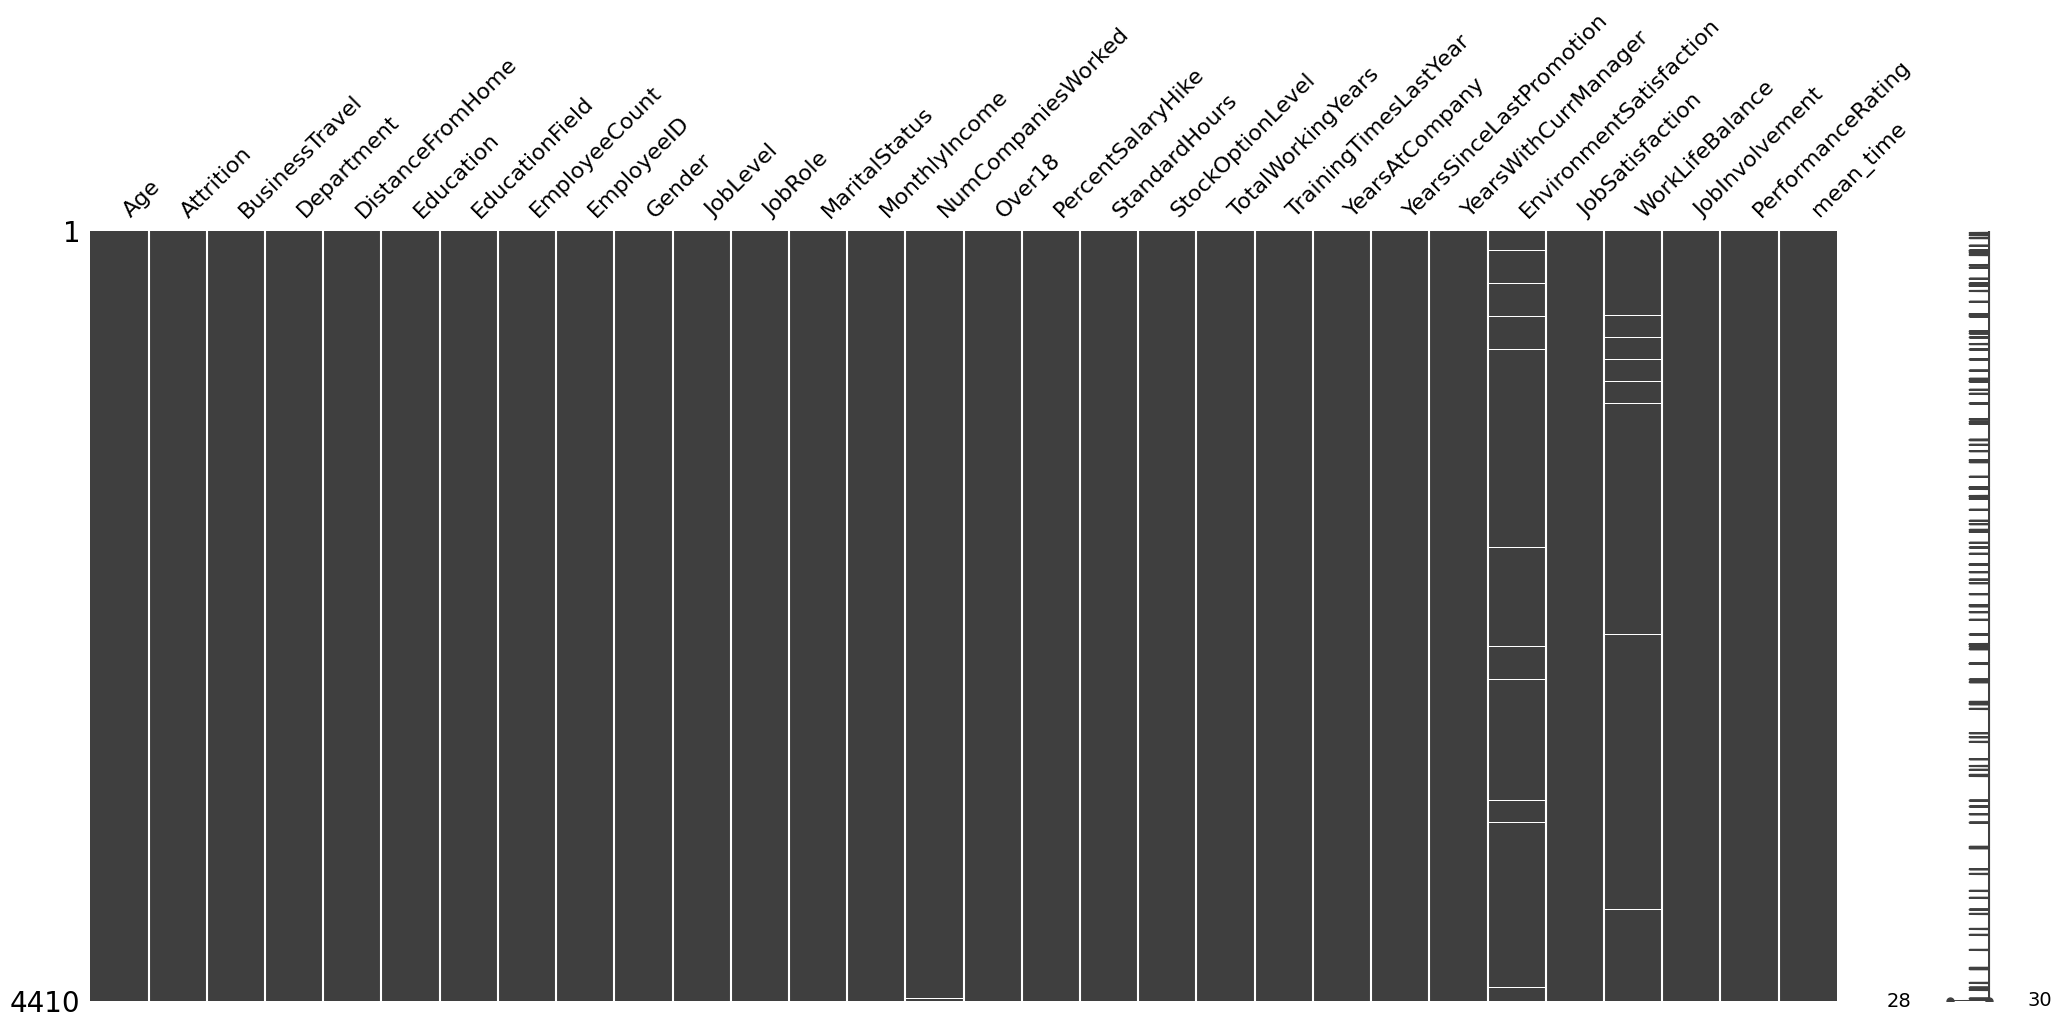

after the filling
numerical_columns :  Index(['Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
       'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'mean_time'],
      dtype='object')
categorical columns :  Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18'],
      dtype='object')


In [60]:

# show missing values
print(df.isnull().sum())

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize missing data
msno.matrix(df)
plt.show()

# Impute missing values
# For numerical columns, use median imputation
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())

# For categorical columns, use mode imputation
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

print("after the filling")
# Verify that there are no more missing values
df.isnull().sum()

import seaborn as sns
import matplotlib.pyplot as plt

# Identify numerical and categorical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
print('numerical_columns : ', numerical_columns)
print('categorical columns : ', categorical_columns)


### 7) Analyse exploratoire (EDA)

Objectifs :
- visualiser la distribution de l’attrition,
- identifier des variables associées au départ,
- produire des insights actionnables RH.


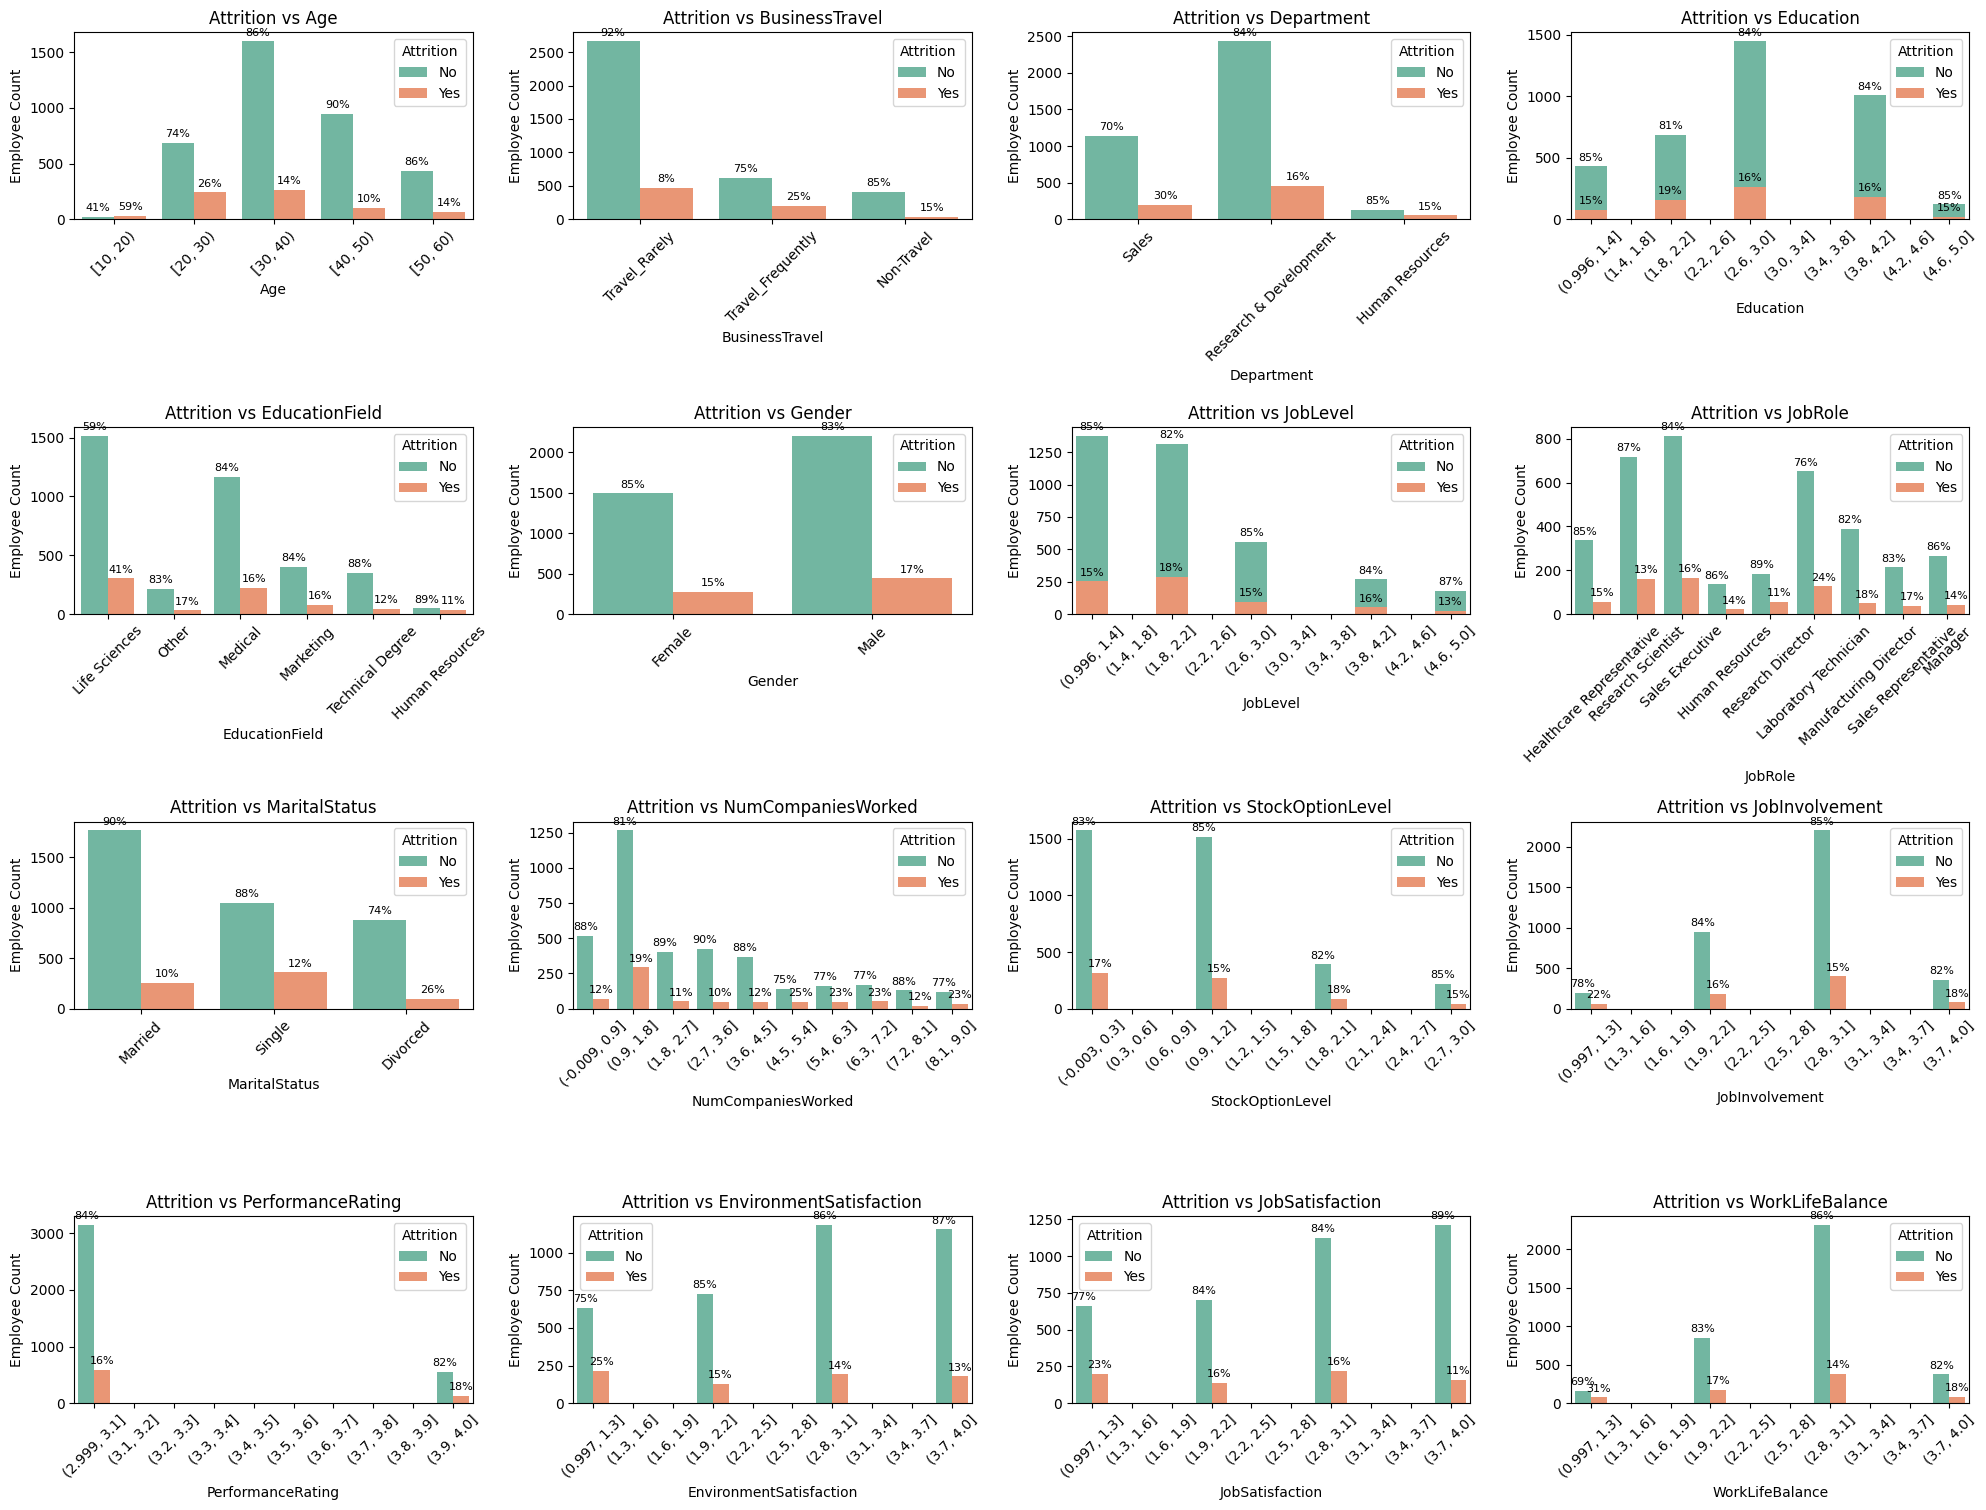

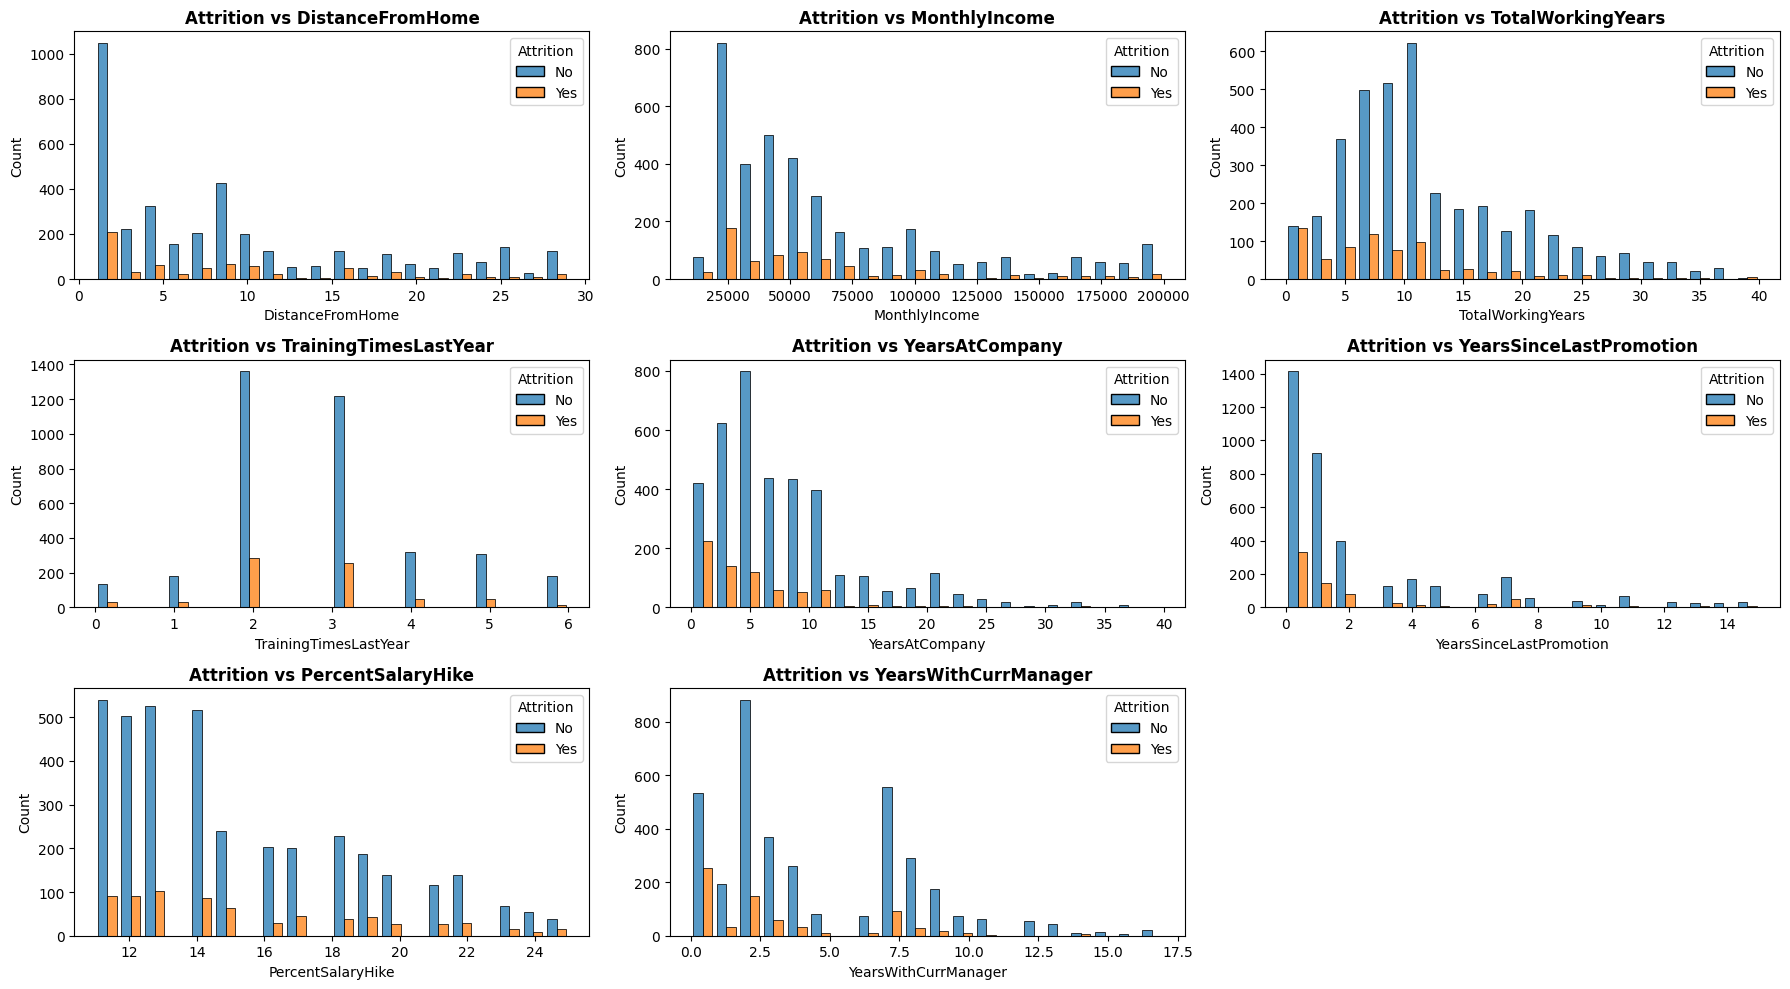

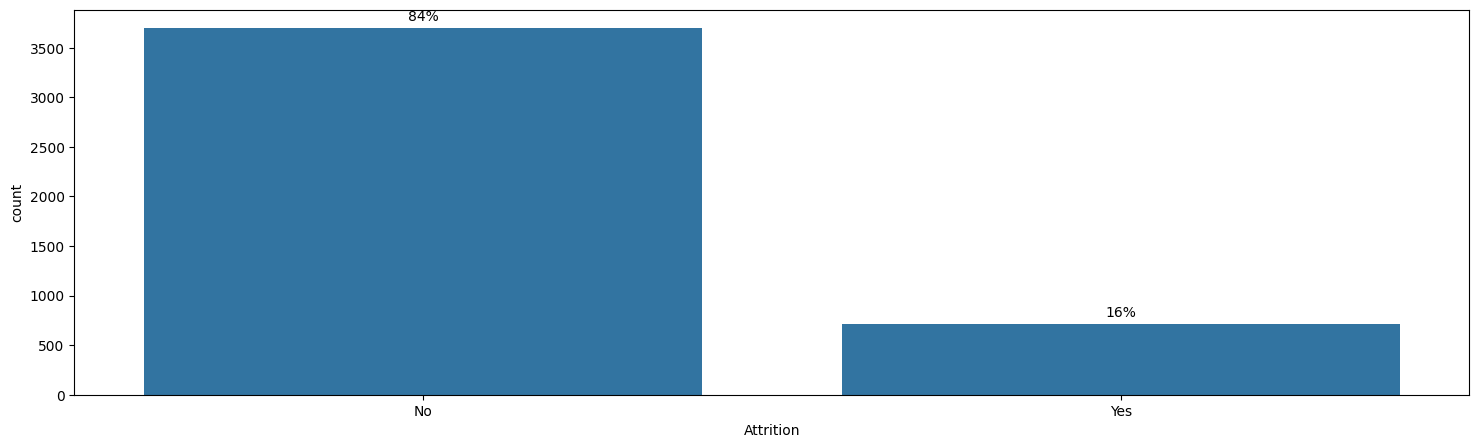

In [61]:
# Exploratory Data Analysis
# put remaining continuous features in a list
continuous_features = ['DistanceFromHome','MonthlyIncome','TotalWorkingYears','TrainingTimesLastYear', 'YearsAtCompany',
'YearsSinceLastPromotion','PercentSalaryHike','YearsWithCurrManager','mean_time']



df_eda = df.copy()
df_eda["Age"] = pd.cut(df_eda["Age"], range(10, 70, 10), right=False)

def add_percent_labels(ax, ct, fontsize=8):
    # ct: index = catégories/bins, colonnes = ["No","Yes"]
    containers = ax.containers
    if len(containers) < 2:
        return

    y_max = ax.get_ylim()[1]
    offset = 0.02 * y_max if y_max > 0 else 1

    for i, cat in enumerate(ct.index):
        total = ct.loc[cat].sum()
        if total == 0:
            continue

        for j, hue in enumerate(ct.columns):  # ["No","Yes"]
            bar = containers[j].patches[i]
            pct = ct.loc[cat, hue] / total
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + offset,
                f"{pct:.0%}",
                ha="center",
                va="bottom",
                fontsize=fontsize
            )

def make_plot(col, order=None, ax=None, bins=10, palette="Set2"):
    ax = ax or plt.gca()
    s = df_eda[col]

    # NUMERIQUE on le transforme en bins (histogramme en catégories) 
    if pd.api.types.is_numeric_dtype(s):
        binned = pd.cut(s, bins=bins)
        tmp = df_eda.copy()
        tmp["_binned_"] = binned

        sns.countplot(
            x="_binned_", hue="Attrition", data=tmp,
            hue_order=["No", "Yes"],
            ax=ax, palette=palette
        )

        ct = pd.crosstab(tmp["_binned_"], tmp["Attrition"]).reindex(columns=["No","Yes"], fill_value=0)
        add_percent_labels(ax, ct)

        ax.set_xlabel(col)
        ax.tick_params(axis="x", rotation=45)

    # CATEGORIEL
    else:
        sns.countplot(
            x=col, hue="Attrition", data=df_eda,
            order=order, hue_order=["No", "Yes"],
            ax=ax, palette=palette
        )

        ct = pd.crosstab(df_eda[col], df_eda["Attrition"]).reindex(columns=["No","Yes"], fill_value=0)
        if order is not None:
            ct = ct.reindex(order).dropna(how="all")

        add_percent_labels(ax, ct)
        ax.tick_params(axis="x", rotation=45)

    ax.set_title(f"Attrition vs {col}")
    ax.set_ylabel("Employee Count")
    ax.legend(title="Attrition")

# Matrice 
cols = [
    "Age","BusinessTravel","Department","Education","EducationField","Gender",
    "JobLevel","JobRole","MaritalStatus","NumCompaniesWorked","StockOptionLevel",
    "JobInvolvement","PerformanceRating","EnvironmentSatisfaction",
    "JobSatisfaction","WorkLifeBalance"
]

orders = {
    "Education": ["Below College","College","Bachelor","Master","Doctor"],
    "JobInvolvement": ["Low","Medium","High","Very High"],
    "EnvironmentSatisfaction": ["Low","Medium","High","Very High"],
    "JobSatisfaction": ["Low","Medium","High","Very High"],
    "WorkLifeBalance": ["Bad","Good","Better","Best"]
}

n_cols = 4
n_rows = (len(cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3.8*n_rows))
axes = axes.ravel()

for ax, col in zip(axes, cols):
    make_plot(col, orders.get(col), ax=ax, bins=10)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# put remaining continuous features in a list (SANS mean_time)
continuous_features = [
    'DistanceFromHome','MonthlyIncome','TotalWorkingYears',
    'TrainingTimesLastYear','YearsAtCompany','YearsSinceLastPromotion',
    'PercentSalaryHike','YearsWithCurrManager'
]

# 8 features → on garde une grille 3x3 et on masque la dernière case
fig, ax = plt.subplots(3, 3, figsize=(18, 10))

index = 0
for i in range(3):
    for j in range(3):

        # si on a déjà tracé toutes les features, on cache le subplot
        if index >= len(continuous_features):
            ax[i][j].set_visible(False)
            continue

        feat = continuous_features[index]
        ax[i][j].set_title(f'Attrition vs {feat}', fontsize=12, fontweight='bold')

        # histogrammes en colonnes, barres côte à côte pour Yes / No
        sns.histplot(
            data=df_eda,
            x=feat,
            hue='Attrition',
            multiple='dodge',
            bins=20,        # à ajuster si tu veux
            shrink=0.8,
            ax=ax[i][j]
        )

        ax[i][j].set_xlabel(feat)
        ax[i][j].set_ylabel('Count')
     
        index += 1

plt.tight_layout()
plt.show()

plt.figure(figsize=(18,5))

ax = sns.countplot(x="Attrition", data=df_eda, order=["No","Yes"])  # optionnel: ordre

total = sum(p.get_height() for p in ax.patches)

for p in ax.patches:
    h = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2,
        h + 0.01*total,                 # petit offset automatique
        f"{h/total:.0%}",
        ha="center",
        va="bottom"
    )

plt.show()



### Insights EDA (résumé)

- overall 16% employee attrition was observed during the year 2015.
- Employees in Human resources are highly prone to quit with an attrition rate of 30%
- similarly employees with human resources education background had an attrition rate of 41%
- 31% of the employees who quit had bad work life balance.
- young and unmarried employees are higly prone to quit with an average attrition rate of 24.5%.
- Employees who traveled frequently were also highly prone to quit with an attrition rate of 25%.
- employees at the lower job levels quit more often than employees on the higher level.
- employees in the research department (research directors and research scientists ) are also prone to quit with an average attrition rate of 21%.
- employees who have worked in more than 4 companies show a much higher attrition rate comapred to rest.
- attrition decreases with increasing environmental satisfaction, job satisfaction and job involvement.
- employee who leave company, worked for longer period of time, it means they could have been in higher work load or were not able to settle in company well.


### 8) Préprocessing / Encodage

Les modèles ML nécessitent des variables numériques :
- One-Hot Encoding pour les catégorielles nominales,
- imputation (médiane/mode),
- standardisation des numériques.

On prépare ensuite `X` et `y`, puis un split train/test stratifié.

Encoding

Machine learning models can only work with numerical values. 

For this reason, it is necessary to transform the categorical values of the relevant features into numerical ones.

This process is called feature encoding.



In [62]:
# Featuring Engineering and Encoding (one hot encoding)

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1) Séparer X / y
df_model = df.copy()
y = (df_model["Attrition"].astype(str).str.strip().str.lower() == "yes").astype(int)
X = df_model.drop(columns=["Attrition"]).copy()

# 2) Convertir colonnes Y/N en 1/0
yn_cols = []
for c in X.columns:
    if X[c].dtype == "object":
        vals = set(X[c].dropna().astype(str).str.strip().str.upper().unique())
        if vals.issubset({"Y", "N"}):
            yn_cols.append(c)
            X[c] = (X[c].astype(str).str.strip().str.upper() == "Y").astype(int)

# Gender (Male/Female) -> 1/0
if "Gender" in X.columns:
    X["Gender"] = (X["Gender"].astype(str).str.strip().str.lower() == "male").astype(int)

# 3) Supprimer identifiant si présent
for id_col in ["EmployeeID", "EmployeeNumber", "ID"]:
    if id_col in X.columns:
        X = X.drop(columns=[id_col])

# 4) Sélection colonnes cat/num
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Y/N columns converted to 0/1:", yn_cols)
print("Categorical one-hot columns:", cat_cols)
print("Numerical columns:", num_cols)
print("Attrition rate:", y.mean())

# 5) Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

print("X_train:", X_train.shape, "| X_test:", X_test.shape)

# 6) Préprocessing (pipeline)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)


Y/N columns converted to 0/1: ['Over18']
Categorical one-hot columns: ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']
Numerical columns: ['Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'Gender', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'mean_time']
Attrition rate: 0.16122448979591836
X_train: (3307, 28) | X_test: (1103, 28)


### Screening rapide avec LazyPredict

On utilise LazyPredict uniquement pour explorer rapidement plusieurs algorithmes (paramètres par défaut).
Pour éviter toute fuite d’information, on fait ce screening sur une validation interne issue de `X_train` (pas sur `X_test`).


In [63]:
from lazypredict.Supervised import LazyClassifier
import lazypredict.Supervised as lps
import tqdm
from sklearn.model_selection import train_test_split
from scipy import sparse
import io, contextlib

# Patch tqdm (évite IProgress/ipywidgets)
lps.notebook_tqdm = tqdm.tqdm

# Split interne (uniquement pour le screening LazyPredict)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=42
)

# Preprocess -> features numériques
X_tr_p  = preprocess.fit_transform(X_tr)
X_val_p = preprocess.transform(X_val)

# LazyPredict est plus stable en dense
if sparse.issparse(X_tr_p):
    X_tr_p = X_tr_p.toarray()
    X_val_p = X_val_p.toarray()

# Limiter les logs
buf = io.StringIO()
lazy_clf = LazyClassifier(verbose=0, ignore_warnings=True)

with contextlib.redirect_stdout(buf), contextlib.redirect_stderr(buf):
    lazy_models, lazy_predictions = lazy_clf.fit(X_tr_p, X_val_p, y_tr, y_val)

print("\n=== LazyPredict: Top modèles (triés par F1) ===")
top15 = lazy_models.sort_values("F1 Score", ascending=False).head(15)

try:
    display(top15)
except NameError:
    print(top15.to_string())



=== LazyPredict: Top modèles (triés par F1) ===


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.97,0.90,0.90,0.97,0.27
XGBClassifier,0.97,0.91,0.91,0.97,0.12
RandomForestClassifier,0.97,0.90,0.90,0.96,0.34
LGBMClassifier,0.96,0.90,0.90,0.96,0.10
LabelPropagation,0.96,0.91,0.91,0.96,0.38
LabelSpreading,0.96,0.91,0.91,0.96,0.49
DecisionTreeClassifier,0.95,0.89,0.89,0.95,0.03
ExtraTreeClassifier,0.95,0.90,0.90,0.95,0.02
BaggingClassifier,0.95,0.87,0.87,0.95,0.15


<br>

### Explications mathématiques des modèles

#### 1) Régression Logistique (LogReg)
On modélise la probabilité d’appartenir à la classe 1 via une **sigmoïde** :

$$
p(y=1\mid x)=\sigma(w^\top x + b)=\frac{1}{1+e^{-(w^\top x+b)}}
$$

Règle de décision (seuil 0.5) :

$$
\hat y = \mathbb{1}[p \ge 0.5]
$$

Apprentissage : minimisation de la *log-loss* + régularisation (souvent L2) :

$$
\min_{w,b}\; \sum_{i=1}^n \Big(-y_i\log p_i-(1-y_i)\log(1-p_i)\Big) + \lambda \|w\|_2^2
$$

Interprétation (*log-odds*) :

$$
\log\frac{p}{1-p}=w^\top x+b
$$

<br>

#### 2) SVM linéaire (LinearSVC)
Hyperplan $w^\top x + b=0$ avec **marge maximale**.  
Avec $y_i\in\{-1,+1\}$, (soft-margin) :

$$
\min_{w,b}\; \frac{1}{2}\|w\|^2 + C\sum_{i=1}^n \max(0, 1 - y_i(w^\top x_i + b))
$$

- $\max(0,1-\cdot)$ = **hinge loss**
- $\|w\|^2$ favorise une grande marge

Décision :

$$
\hat y = \mathrm{sign}(w^\top x + b)
$$

<br>

#### 3) Random Forest
Ensemble de $T$ arbres. Critère courant : impureté de **Gini** :

$$
Gini(S)=1-\sum_k p_k^2
$$

Vote majoritaire :

$$
\hat y = \mathrm{mode}\{\hat y^{(1)},\dots,\hat y^{(T)}\}
$$

<br>

#### 4) XGBoost (Gradient Boosting)
Modèle additif :

$$
\hat y(x)=\sum_{t=1}^{T} f_t(x), \quad f_t \in \text{arbres}
$$

Objectif :

$$
\mathcal{L}=\sum_{i} \ell(y_i,\hat y_i) + \sum_{t}\Omega(f_t)
$$

Mise à jour :

$$
\hat y^{(t)} = \hat y^{(t-1)} + \eta f_t(x)
$$

<br>

### 9) Modèles candidats

On définit plusieurs modèles supervisés (classification binaire) et on compare leurs performances via validation croisée stratifiée sur le train.


In [64]:

models = {
    "LogReg": LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ),
    "SVM": LinearSVC(
        class_weight="balanced",
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ),
}

if XGBOOST_OK:
    models["XGBoost"] = XGBClassifier(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    )


### 10) Comparaison des modèles (Cross-Validation)

On évalue chaque modèle sur le train uniquement avec `StratifiedKFold`, puis on trie par F1 (compromis précision/rappel).


In [65]:
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate



def to_dense(X):
    return X.toarray() if sparse.issparse(X) else X

densify = FunctionTransformer(to_dense, accept_sparse=True)

def make_pipe(model_name, model):
    # RandomForest -> densifier après preprocess, sinon laisser en sparse
    if model_name == "RandomForest":
        return Pipeline(steps=[
            ("prep", preprocess),
            ("densify", densify),
            ("model", model)
        ])
    else:
        return Pipeline(steps=[
            ("prep", preprocess),
            ("model", model)
        ])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
}

cv_results = []

for name, model in models.items():
    pipe = make_pipe(name, model)
    scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    cv_results.append({
        "model": name,
        "cv_accuracy_mean": scores["test_accuracy"].mean(),
        "cv_accuracy_std":  scores["test_accuracy"].std(),
        "cv_f1_mean":       scores["test_f1"].mean(),
        "cv_f1_std":        scores["test_f1"].std(),
        "cv_precision_mean":scores["test_precision"].mean(),
        "cv_recall_mean":   scores["test_recall"].mean(),
    })

cv_results_df = pd.DataFrame(cv_results).sort_values("cv_f1_mean", ascending=False)

print("\n=== Résultats Cross-Validation (triés par F1) ===")
try:
    display(cv_results_df)
except NameError:
    print(cv_results_df.to_string(index=False))

best_model_name = cv_results_df.iloc[0]["model"]

best_pipe = make_pipe(best_model_name, models[best_model_name])
best_pipe.fit(X_train, y_train)

print("Best model (CV):", best_model_name)




=== Résultats Cross-Validation (triés par F1) ===


,model,cv_accuracy_mean,cv_accuracy_std,cv_f1_mean,cv_f1_std,cv_precision_mean,cv_recall_mean
2,RandomForest,0.97,0.01,0.91,0.03,0.99,0.85
3,XGBoost,0.97,0.01,0.91,0.03,0.95,0.87
0,LogReg,0.73,0.02,0.48,0.03,0.35,0.75
1,SVM,0.73,0.02,0.47,0.02,0.34,0.74


Best model (CV): RandomForest


### 11) Modèle final (train complet) + évaluation sur test

On réentraîne le meilleur modèle sur tout le train et on évalue sur le test (hold-out).
On affiche aussi la ROC et l’AUC si les probabilités sont disponibles.



=== Test set performance (hold-out) ===
Accuracy  : 0.988
Precision : 1.0
Recall    : 0.927
F1        : 0.962

Confusion Matrix
 [[925   0]
 [ 13 165]]

Classification Report
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       925
           1       1.00      0.93      0.96       178

    accuracy                           0.99      1103
   macro avg       0.99      0.96      0.98      1103
weighted avg       0.99      0.99      0.99      1103



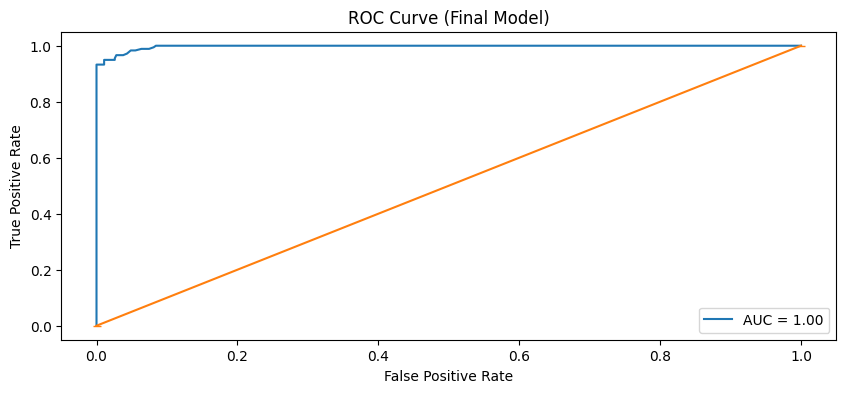

In [66]:
best_model_name = cv_results_df.iloc[0]["model"]

m_final = make_pipe(best_model_name, models[best_model_name])
m_final.fit(X_train, y_train)

y_pred = m_final.predict(X_test)


print("\n=== Test set performance (hold-out) ===")
print("Accuracy  :", round(accuracy_score(y_test, y_pred), 3))
print("Precision :", round(precision_score(y_test, y_pred), 3))
print("Recall    :", round(recall_score(y_test, y_pred), 3))
print("F1        :", round(f1_score(y_test, y_pred), 3))
print("\nConfusion Matrix\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report\n", classification_report(y_test, y_pred))

# Score pour ROC: proba si dispo, sinon decision_function, sinon fallback
model_step = m_final.named_steps["model"]
if hasattr(model_step, "predict_proba"):
    y_score = m_final.predict_proba(X_test)[:, 1]
elif hasattr(model_step, "decision_function"):
    y_score = m_final.decision_function(X_test)
else:
    y_score = y_pred.astype(float)

fpr, tpr, _ = roc_curve(y_test, y_score)
area = auc(fpr, tpr)

plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label=f"AUC = {area:.2f}")
plt.plot([0, 1], [0, 1], marker="_")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Final Model)")
plt.legend(loc="lower right")
plt.show()


### 12) Conclusion et recommandations RH

- Résumer le meilleur modèle + métriques (F1/Recall/Precision/AUC),
- Rappeler 4–6 facteurs principaux observés (EDA + modèle),
- Proposer 3–6 actions RH concrètes,
- Mentionner les limites (données manquantes, biais potentiels, corrélation ≠ causalité),
- Proposer des next steps (seuil métier, PR-AUC, calibration, monitoring).
